## Feature effect with piecewise-linear parts of different size

#### Goal
* Show that if feature effect contains both high and low resolution parts, fixed-bin size approaches fail.
  - If we choose a small K(=nof bins) => small bin size, then bin effect is very noisy (interpolation is erroneous)
  - If we choose a big K => large bin width, then we loose all high-resolution artifacts
* Show that variable-bin size can create the bins correctly



In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
import numpy as np
import examples.example_utils as utils
import feature_effect as fe

In [3]:
def f_params():
    def find_a(params, x_start):
        params[0]["a"] = x_start
        for i, param in enumerate(params):
            if i < len(params) - 1:
                a_next = param["a"] + (param["to"] - param["from"]) * param["b"]
                params[i + 1]["a"] = a_next

    params = [{"b":10, "from": 0., "to": 5.},
              {"b":-10, "from": 5., "to": 10.},
              {"b":0. , "from": 10., "to": 100}]

    x_start = -25.
    find_a(params, x_start)
    return params


# generate samples
def generate_samples(N):
    eps = 1e-05
    x1 = np.random.uniform(0., 5, size=int(N / 3))
    x2 = np.random.uniform(5, 10, size=int(N / 3))
    x3 = np.random.uniform(10, 99, size=int(N / 3))
    x = np.expand_dims(np.concatenate((np.array([0.0]), x1, x2, x3, np.array([100-eps]))), axis=-1)
    return x

In [4]:
N = 5000
noise_level = 3.
K_max_fixed = 50
K_max_var = 50
min_points_per_bin = 10

In [5]:
# init functions
seed = 4834545
np.random.seed(seed)

model = utils.create_f1_center(f_params)
model_jac = utils.create_data_effect(f_params, noise_level, seed)
data = generate_samples(N=N)
y = model(data)
data_effect = model_jac(data)

# DALE fixed-size interactive

In [6]:
dale = fe.DALE(data=data, model=model, model_jac=model_jac)
def plot(bins):
    dale.fit(features=[0], alg_params={"nof_bins": bins})
    dale.plot(s=0, block=False, gt=model)
    plt.show()

dale_plot = widgets.interactive(plot, bins=(1, 100, 1))
dale_output = dale_plot.children[-1]
dale_output.layout.height = '400px'
dale_plot

interactive(children=(IntSlider(value=50, description='bins', min=1), Output(layout=Layout(height='400px'))), …

# DALE variable-size interactive

In [7]:
dale = fe.DALE(data=data, model=model, model_jac=model_jac)
gt_bins = utils.create_gt_bins(f_params)
def plot(bins):
    dale.fit(features=[0], alg_params={"max_nof_bins": bins}, method = "variable-size")
    # dale.plot(s=0, block=False, gt=model)
    
    lims = dale.dale_params["feature_0"]["limits"]
    positions = [(lims[i] + (lims[i+1] - lims[i])/2) for i in range(len(lims) - 1)]
    dx = [lims[i+1]-lims[i] for i in range(len(lims) - 1)]
    height = dale.dale_params["feature_0"]["bin_effect"]
    plt.bar(x=positions, height=height, width=dx, color=(0.1, 0.1, 0.1, 0.1), edgecolor='blue', label="bin estimation")

    
    lims = gt_bins["limits"]
    positions = [(lims[i] + (lims[i+1] - lims[i])/2) for i in range(len(lims) - 1)]
    height = gt_bins["height"]
    dx = [lims[i+1]-lims[i] for i in range(len(lims) - 1)]
    plt.bar(x=positions, height=height, width=dx, color=(0.1, 0.1, 0.1, 0.1), edgecolor='red', label="bin gt")
    
    plt.legend()
    plt.show()

dale_plot = widgets.interactive(plot, bins=(1, 66, 1))
dale_output = dale_plot.children[-1]
dale_output.layout.height = '400px'
dale_plot

interactive(children=(IntSlider(value=33, description='bins', max=66, min=1), Output(layout=Layout(height='400…

In [8]:
k_list_fixed, mse_fixed, loss_fixed, dale_fixed = utils.count_loss_mse(K_max_fixed, model, data, model, model_jac,
                                                                       min_points_per_bin, method="fixed-size")
k_list_var, mse_var, loss_var, dale_var = utils.count_loss_mse(K_max_var, model, data, model, model_jac,
                                                               min_points_per_bin, method="variable-size")

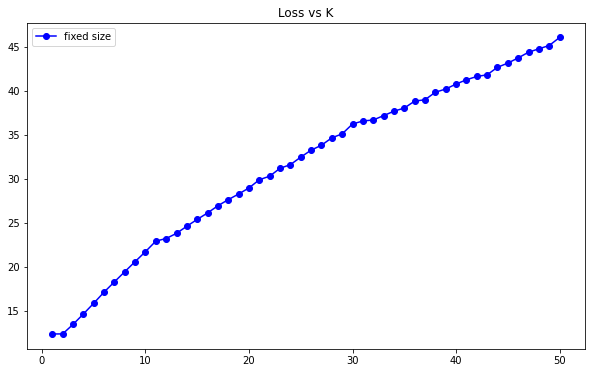

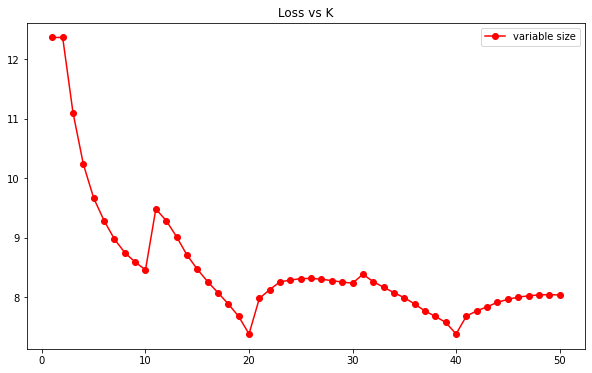

In [9]:
# plot
plt.figure()
plt.title("Loss vs K")
plt.plot(k_list_fixed, loss_fixed, "bo-", label="fixed size")
plt.legend()
plt.show(block=False)

plt.figure()
plt.title("Loss vs K")
plt.plot(k_list_var, loss_var, "ro-", label="variable size")
plt.legend()
plt.show(block=False)


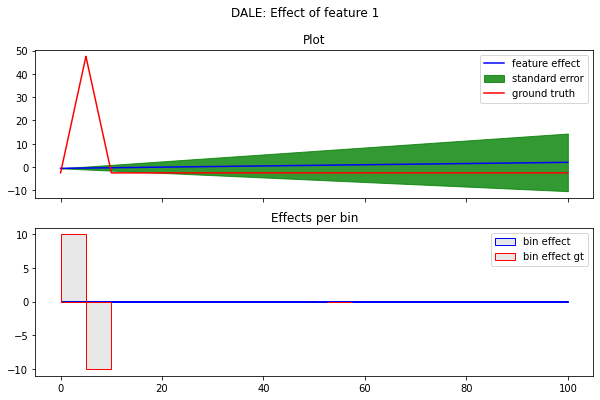

In [10]:
# plot best fixed solution
best_fixed = np.nanargmin(loss_fixed)
dale_fixed[best_fixed].plot(s=0,
                            gt=model,
                            gt_bins=utils.create_gt_bins(f_params),
                            block=False)


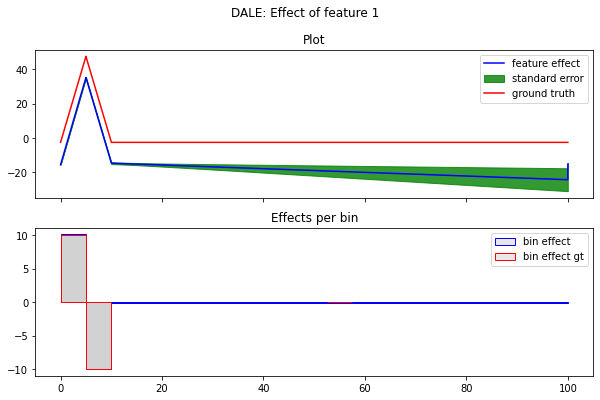

In [11]:
# plot best variable size solution
best_var = np.nanargmin(loss_var)
dale_var[best_var].plot(s=0,
                        gt=model,
                        gt_bins=utils.create_gt_bins(f_params),
                        block=False)


# DALE fixed-size: best solution based on auto algorithm

In [12]:
best_fixed = np.nanargmin(loss_fixed)
print("===========================================")
print("Best K is: %2d, with loss=%.3f" % (best_fixed+1, loss_fixed[best_fixed]))

print("===========================================")
print("Dx is: %.3f" %(dale_fixed[best_fixed].dale_params["feature_0"]["dx"]))

print("===========================================")
print("Effect per bin is:")
print(dale_fixed[best_fixed].dale_params["feature_0"]["bin_effect"])

print("===========================================")
print("Loss per K:")
for i, k in enumerate(k_list_fixed):
    print("Fixed-size k= %d, loss=%.3f" % (k, loss_fixed[i]))

Best K is:  1, with loss=12.367
Dx is: 100.000
Effect per bin is:
[0.02569916]
Loss per K:
Fixed-size k= 1, loss=12.367
Fixed-size k= 2, loss=12.374
Fixed-size k= 3, loss=13.453
Fixed-size k= 4, loss=14.634
Fixed-size k= 5, loss=15.857
Fixed-size k= 6, loss=17.125
Fixed-size k= 7, loss=18.289
Fixed-size k= 8, loss=19.443
Fixed-size k= 9, loss=20.588
Fixed-size k= 10, loss=21.724
Fixed-size k= 11, loss=22.921
Fixed-size k= 12, loss=23.214
Fixed-size k= 13, loss=23.805
Fixed-size k= 14, loss=24.615
Fixed-size k= 15, loss=25.389
Fixed-size k= 16, loss=26.122
Fixed-size k= 17, loss=26.940
Fixed-size k= 18, loss=27.634
Fixed-size k= 19, loss=28.274
Fixed-size k= 20, loss=28.966
Fixed-size k= 21, loss=29.892
Fixed-size k= 22, loss=30.300
Fixed-size k= 23, loss=31.198
Fixed-size k= 24, loss=31.606
Fixed-size k= 25, loss=32.465
Fixed-size k= 26, loss=33.255
Fixed-size k= 27, loss=33.815
Fixed-size k= 28, loss=34.654
Fixed-size k= 29, loss=35.107
Fixed-size k= 30, loss=36.227
Fixed-size k= 31, 

# DALE variable-size: best solution based on auto algorithm

In [13]:
best_var = np.nanargmin(loss_var)
print("===========================================")
print("Best K is: %2d, with loss=%.3f" % (best_var+1, loss_var[best_var]))

print("===========================================")
print("Bin limits are:")
print(dale_var[best_var].dale_params["feature_0"]["limits"])

print("===========================================")
print("Effect per bin is:")
print(dale_var[best_var].dale_params["feature_0"]["bin_effect"])

print("===========================================")
print("Loss per K:")
for i, k in enumerate(k_list_var):
    print("Fixed-size k= %d, loss=%.3f" % (k, loss_var[i]))

Best K is: 20, with loss=7.387
Bin limits are:
[ 0.          4.9999995   9.999999   99.99999002]
Effect per bin is:
[10.14005531 -9.96226015 -0.10668924]
Loss per K:
Fixed-size k= 1, loss=12.367
Fixed-size k= 2, loss=12.367
Fixed-size k= 3, loss=11.103
Fixed-size k= 4, loss=10.237
Fixed-size k= 5, loss=9.667
Fixed-size k= 6, loss=9.291
Fixed-size k= 7, loss=8.980
Fixed-size k= 8, loss=8.753
Fixed-size k= 9, loss=8.594
Fixed-size k= 10, loss=8.465
Fixed-size k= 11, loss=9.486
Fixed-size k= 12, loss=9.291
Fixed-size k= 13, loss=9.021
Fixed-size k= 14, loss=8.715
Fixed-size k= 15, loss=8.475
Fixed-size k= 16, loss=8.266
Fixed-size k= 17, loss=8.081
Fixed-size k= 18, loss=7.890
Fixed-size k= 19, loss=7.682
Fixed-size k= 20, loss=7.387
Fixed-size k= 21, loss=7.983
Fixed-size k= 22, loss=8.131
Fixed-size k= 23, loss=8.263
Fixed-size k= 24, loss=8.291
Fixed-size k= 25, loss=8.317
Fixed-size k= 26, loss=8.319
Fixed-size k= 27, loss=8.307
Fixed-size k= 28, loss=8.283
Fixed-size k= 29, loss=8.25